### Box Gym Environment Tutorial

*Date: May 25, 2025*, *Author: Max M. Sun*

This notebook is a tutorial for the box gym environment. It contains a sensor agent (robot) with a 2d single integrator dynamics (controlled by velocity), which samples binary signals from the environment and aims to find an underlying rectanglar box.

The environment has a built-in prediction function, which is a "generative model" that predicts possible boxes (location + dimensions) given the signals received so far.

Your goal is to control the robot to move across the space to collect signal measurements, such that the uncertainty (variance) of the box predictions drops below a predefine threshold as quickly as possible.

In [1]:
# uncomment and run the line below to download the box_gym environment code
!curl -o box_gym.py https://raw.githubusercontent.com/MurpheyLab/ME455_public/refs/heads/main/box_gym_project/box_gym.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13174  100 13174    0     0  56294      0 --:--:-- --:--:-- --:--:-- 56540


In [2]:
# import regular packages
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=4)
np.seterr(divide='ignore', invalid='ignore')
import time

# import the playground environment
from box_gym import BoxGymBase

In [24]:
# Obstacles are circles with a center and a radius
class Obstacle:
    def __init__(self, id, center, radius, influence_scale):
        self.id = id
        self.center = np.array(center)
        self.radius = radius
        self.influence_scale = influence_scale
        self.influence_radius = radius * influence_scale

    def contains(self, point):
        return np.linalg.norm(point - self.center) <= self.radius

    def is_influenced(self, point):
        return np.linalg.norm(point - self.center) <= self.influence_radius

    def __eq__(self, value):
        if isinstance(value, Obstacle):
            return self.id == value.id
        return False


class PotentialField:
    def __init__(self, goal, attractive_gain=0.4, repulsive_gain=0.25):
        self.goal = np.array(goal)
        self.obstacles: list[Obstacle] = []
        self.attractive_gain = attractive_gain
        self.repulsive_gain = repulsive_gain

    def reset(self):
        self.goal = np.array([0.0, 0.0])
        self.obstacles = []

    def update_goal(self, goal):
        self.goal = np.array(goal)

    def add_obstacle(self, center, radius, influence_scale):
        # Hash the center to create a unique ID for the obstacle
        # This should be done in such a way that obstacles with different centers are different
        # and equivalance is only based on the center
        id = hash(tuple(center))
        if not any(obst.id == id for obst in self.obstacles):
            obst = Obstacle(id, center, radius, influence_scale)
            self.obstacles.append(obst)

    def compute_attraction(self, state):
        # State = [x, y]
        #  Equation: F = -attractiveGain * (distace * direction)
        distance = np.linalg.norm(state[:2] - self.goal)
        if distance < 1e-6:
            return np.zeros(2)
        direction = (self.goal - state[:2]) / distance
        return self.attractive_gain * (distance * direction)

    def compute_repulsion(self, state):
        # Equation: F = repulsiveGain * (1/distance - 1/influence) * (1 / distance^2) * direction
        # invDistance = 1.0 / distance
        # distSquared = distance**2
        # direction = (state[:2] - self.goal) / distance
        repulsive_vector = [0.0, 0.0]
        for obst in self.obstacles:
            if obst.is_influenced(state[:2]):
                distance = np.linalg.norm(state[:2] - obst.center)
                if distance < 1e-6:
                    continue
                direction = (state[:2] - obst.center) / distance
                inv_distance = 1.0 / distance
                repulsive_vector += -self.repulsive_gain * \
                    (1.0 / obst.influence_radius - inv_distance) * \
                    (1.0 / distance**2) * direction
        return np.array(repulsive_vector)

    def compute_velocity(self, state):
        velocity = np.zeros(2)
        velocity += self.compute_attraction(state)
        velocity += self.compute_repulsion(state)
        return velocity  # [vx, vy]

class BoxGym(BoxGymBase):
    def __init__(
            self,
            seed=0, # seed for random number generator
            dt=0.1, # time interval
            sensor_box_size=0.2, # field of view of the sensor box
            num_sensor_samples=10, # number of samples drawn within the FoV per time step
            max_velocity=0.05, # maximum velocity of the agent (sensor)
            inference_num=100, # number of boxes to be inferred from the data collected so far
        ):
        super(BoxGym, self).__init__(seed, dt, sensor_box_size, num_sensor_samples, max_velocity, inference_num)
        self.sensor_pos_traj = []
        self.PF = PotentialField(goal=np.array([0,0]), attractive_gain=0.4, repulsive_gain=0.25)
        self.negative_measurements_needed = 20 # number of negative measurements needed to add an obstacle

    def plot(self):
        # Add your own (matplotlib) visualization code here
        # for example, we can visualize the trajectory of the sensor as blue dots
        ax = self.ax  # "ax" here is equivalent to "fig, ax = plt.subplots(...)"
        traj_np = np.array(self.sensor_pos_traj)
        ax.plot(traj_np[:,0], traj_np[:,1], linestyle='', marker='o', markersize=3, color='blue', alpha=0.3)
        # visualize the obstacles as orange circles
        for obst in self.PF.obstacles:
            circle = plt.Circle(obst.center, obst.radius, color='orange', alpha=0.5)
            influence_circle = plt.Circle(obst.center, obst.influence_radius, color='yellow', alpha=0.2, linestyle='--')
            ax.add_artist(circle)
        # Visualize the goal as a green star
        ax.plot(self.PF.goal[0], self.PF.goal[1], marker='*', markersize=10, color='green', alpha=0.7)
        # Keep this line to visualize the default information (positive and negative samples, predicted boxes)
        super().plot()

    def plan(
            self,
            obs # the "obs" variable returned from the "step()" function
        ) -> np.ndarray:
        # What does the "obs" variable include?

        # current postion of the sensor
        sensor_pos = obs['sensor_pos']
        # positions of the positive signals from the lastest measurement
        curr_positive = obs['curr_positive']
        # positions of the negative signals from the lastest measurement
        curr_negative = obs['curr_negative']
        # positions of all the positive signals from the all the measurements so far
        hist_positive = obs['hist_positive']
        # positions of all the negative signals from the all the measurements so far
        hist_negative = obs['hist_negative']
        # predicted boxes (samples) based on the all the signals (positive and negative) so far,
        # using the built-in prediction function from the BoxGymBase environment
        # pred_boxes is a numpy array with the shape (N, 4), N being the number of predicted samples
        # the first column contains the x coordinates of the bottom left corner of the boxes
        # the second column contains the y coordinates of the bottom left corner of the boxes
        # the third column contains the x coordinates of the upper right corner of the boxes
        # the fourth column contains the y coordinates of the upper right corner of the boxes
        pred_boxes = obs['pred_boxes']
        # print(f'pred_boxes.shape: {pred_boxes.shape}')

        # for example, we can keep track of the positions of the sensor over time
        self.sensor_pos_traj.append(sensor_pos)
        
        # For all of the negative points, we can add them as obstacles to the potential field
        # Instead of all of them, add the centroid of the negative points to the potential field
        if len(curr_negative) > 0 and len(curr_negative) >= self.negative_measurements_needed:
            # Only do this when there are enough negative points to form a centroid
            negative_centroid = np.mean(curr_negative, axis=0)
            self.PF.add_obstacle(center=negative_centroid, radius=0.035, influence_scale=1.5)
        
        # Find the centroid of the positive points if there are any
        if len(curr_positive) > 0:
            goal = np.mean(curr_positive, axis=0)
        else: # If there are no positive points, use the centroid of the predicted boxes as the goal
            if pred_boxes.shape[0] > 0:
                # Calculate the centroid of the predicted boxes
                box_centers = (pred_boxes[:, :2] + pred_boxes[:, 2:]) / 2.0
                goal = np.mean(box_centers, axis=0)
            else:
                # If there are no predicted boxes, use the a random point far away from the cluster of
                # negative points
                negative_centroid = np.mean(hist_negative, axis=0) if len(hist_negative) > 0 else np.array([0.0, 0.0])
                goal = negative_centroid + np.random.uniform(-0.5, 0.5, size=2)
        # Ensure the goal is within the bounds of the environment
        goal = np.clip(goal, -1.0, 1.0)
        # Update the goal in the potential field
        self.PF.update_goal(goal)
        
        # Obtain a velocity vector from the potential field
        velocity = self.PF.compute_velocity(np.array(sensor_pos))
        # Normalize the velocity vector to ensure it does not exceed the maximum velocity
        norm = np.linalg.norm(velocity)
        if norm > self.max_velocity:
            velocity = (velocity / norm) * self.max_velocity
        # Convert the velocity vector to an action [vx, vy] in the range [-1.0, 1.0]
        action = np.clip(velocity / self.max_velocity, -1.0, 1.0)

        return action


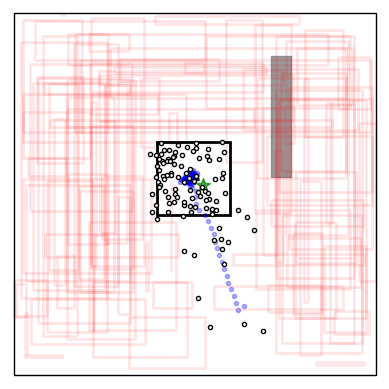

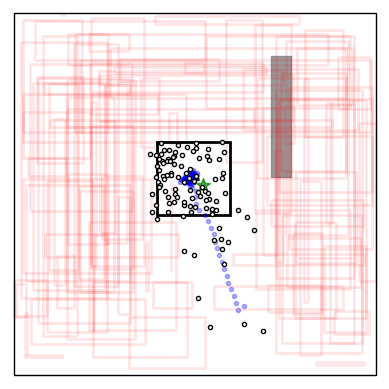

In [23]:
env = BoxGym(seed=12, sensor_box_size=0.2, num_sensor_samples=1, max_velocity=0.2, inference_num=100)
obs = env.reset()  # reset and re-randomize the environment

num_tsteps = 100  # number of total time steps for the experiment
for t in range(num_tsteps):
    # plan an action, which is the velocity of the robot/sensor
    # the robot is a 2d point mass with single-integrator dynamics (velocity-based control)
    action = env.plan(obs)

    # execute the action, receive new observation/information
    obs, cost, done, trash = env.step(action)  # cost is the variance of the predicted boxes

    # visualize the environment
    env.render(mode='notebook')   # choose mode='gui' if you are writing a local python script

    # if the cost is lower than the predefined threshold, task is successful
    if done:
        print(f'success in {t} steps!')
        break